## Door Dash Estimated Delivery Time Prediction 

### 1. Data Preparation 

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns  
import numpy as np 

In [4]:
df = pd.read_csv("historical_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [5]:
df.shape

(197428, 16)

In [6]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [7]:
from datetime import datetime      

# Since both of the features below are of object type , we convert them to datetime type 
df["created_at"] = pd.to_datetime(df["created_at"])
# Note : ' df["created_at"] = pd.to_datetime(df["created_at"]).dt.second ' extracts the 'seconds' part in the each timestamp  

df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

In [8]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [9]:
#our target variable (converting them to seconds)
df["actual_delivery_duration"] = (df["actual_delivery_time"]-df["created_at"]).dt.total_seconds()


In [10]:
''' 
Feature engineering raw features to make them more relevant to our problem.  
-------------------------------------------------------------------
- Busy dashers ratio % =  total busy dashers / total onshift dashers  
- When the busy dashers ratio increases, the dasher capacity will reduce which leads to longer delivery duration 
Example : 
a) 100/200 = 0.5 (100 is the  number of busy dashers, 200 is the total dashers available in shift)  
b) 150/200 = 0.75  (150 is the number of busy dashers, 200 is the total dashers available in shift)
The higher the availability of dashers, the higher the probability of any one of the dashers picking up the order (in this case (a) has higher probability).     
'''  

df["busy_dashers_ratio"] = df["total_busy_dashers"] / df["total_onshift_dashers"] 


In [11]:
# We want to estimate the time taken for the food to reach the house of the customer from the point they make an order ..therefore , we need to take into account other potential scenarios
# which may influence the estimation such as the tiem taken to receive the order, time taken to prepare the meals, time taken from store to the customer house (that is what we're doing below)  
df['estimated_nonprep_duration'] = df["estimated_store_to_consumer_driving_duration"] + df["estimated_order_place_duration"] 
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_dashers_ratio,estimated_nonprep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [12]:
#Checking the number of unique values
print(df["market_id"].nunique())
print(df["market_id"].unique()) 

6
[ 1.  2.  3.  4. nan  5.  6.]


In [13]:
#Checking the number of unique values
df["store_id"].nunique()  

6743

In [14]:
#Checking the number of unique values
print(df["order_protocol"].nunique()) #to check the count unique values are there
print(df["order_protocol"].unique())  #to check what are the unique values

7
[ 1.  2.  3.  4. nan  5.  6.  7.]


In [15]:
#Creating dummies for "order_protocol"  (one hot encoding) 
order_protocol_dummies = pd.get_dummies(df["order_protocol"])
order_protocol_dummies = order_protocol_dummies.add_prefix("order_protocol_")
order_protocol_dummies.head() 

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,True,False,False,False,False,False,False
1,False,True,False,False,False,False,False
2,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False


In [16]:
#creating dummies for "market_id"  
market_id_dummies = pd.get_dummies(df["market_id"])
market_id_dummies = market_id_dummies.add_prefix("market_id_")
market_id_dummies.head() 

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,True,False,False,False,False,False
1,False,True,False,False,False,False
2,False,False,True,False,False,False
3,False,False,True,False,False,False
4,False,False,True,False,False,False


In [17]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_dashers_ratio,estimated_nonprep_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [18]:
#We're focusing on store_category rather than store_id  
#We want to fill in all the missing values/null in store_primary_category 
#As we can see above , for store_id=5477 , there are some store_primary_category that has null values. Therefore , we are using the relatiomship between store_id and store_primary_category to fill in the missing values.
#Process : 1) Store the store_id associating with its mode in a dictionary , 2) Form a new column that will have NaN free value for store_primary_category by imputing the value based on its store_id which can be retrieved from dictionary 


#1) Creating a reference dictionary which maps each store_id to the most frequent cuisine_category they have
store_id_unique = df.store_id.unique().tolist()
storeID_and_category = {store_id: df[df["store_id"] == store_id].store_primary_category.mode()
                        for store_id in store_id_unique}  

'''
Explanation for :  df[df["store_id"] == store_id].store_primary_category.mode() 
df[df["store_id"] == store_id] - filtering to only include rows with the specific store id (in this case from the looping of store_id_unique)
.store_primary_category - then return this column 
.mode() - from the returned column , find the mode value and returns a list of mode values (because there might be more than one element that has the same highest value)

In the case of a tie, all the modes are returned as a list. If there is no tie, it still returns a list (of length 1) for consistency. 

'''

#Looping through the reference dictionary 
for store_id, categories_series in storeID_and_category.items():
    categories_list = categories_series.tolist()
    print(f"Store ID: {store_id}, Categories: {categories_list}") 

Store ID: 1845, Categories: ['american']
Store ID: 5477, Categories: ['indian', 'mexican']
Store ID: 2841, Categories: ['italian']
Store ID: 4139, Categories: ['mexican']
Store ID: 5058, Categories: ['italian']
Store ID: 4149, Categories: ['sandwich', 'thai']
Store ID: 3201, Categories: ['cafe']
Store ID: 5054, Categories: ['italian']
Store ID: 2004, Categories: ['american']
Store ID: 1984, Categories: ['chinese']
Store ID: 4905, Categories: ['mexican']
Store ID: 1698, Categories: ['sandwich']
Store ID: 1936, Categories: ['singaporean']
Store ID: 6015, Categories: ['burger']
Store ID: 976, Categories: ['breakfast']
Store ID: 5081, Categories: ['mediterranean']
Store ID: 1019, Categories: ['chinese']
Store ID: 3994, Categories: ['japanese']
Store ID: 6395, Categories: ['cafe']
Store ID: 3879, Categories: []
Store ID: 6517, Categories: ['american']
Store ID: 6584, Categories: ['catering']
Store ID: 4003, Categories: ['mexican']
Store ID: 1848, Categories: ['sandwich']
Store ID: 3654, Cat

In [19]:
df["store_id"].isnull().any() 

False

In [20]:
def fill(store_id): 
    try:
        # return storeID_and_category[store_id].values  -- mode returns a list , thats why we're using [0] to get the first index  
        return storeID_and_category[store_id].values[0]
    except:
        return np.nan 
    
#2) Filling the null values (nan_free means there's no null values)   
df["nan_free_store_primary_category"] = df.store_id.apply(fill) #when we call .store_id.apply(func) , we are literally passing each values in store_id into the func

df["nan_free_store_primary_category"]

0         american
1           indian
2           indian
3           indian
4           indian
            ...   
197423        fast
197424        fast
197425        fast
197426    sandwich
197427    sandwich
Name: nan_free_store_primary_category, Length: 197428, dtype: object

In [21]:
#Creating dummies for "nan_free_store_primary_category"   

store_primary_category_dummies = pd.get_dummies(df["nan_free_store_primary_category"])
store_primary_category_dummies = store_primary_category_dummies.add_prefix("category_")
store_primary_category_dummies.head(10) 

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
# df["store_primary_category"].isnull().any()  returns true if any one of the row has null values , else false 
df["store_primary_category"].isnull().sum() 

4760

In [23]:
df["nan_free_store_primary_category"].isnull().sum() #we have reduced the number of rows with null values from 4760 to 867 

867

In [24]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_dashers_ratio,estimated_nonprep_duration,nan_free_store_primary_category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0,indian


In [25]:
df2 = df.drop(columns=["created_at","market_id","store_id","store_primary_category","actual_delivery_time","nan_free_store_primary_category","order_protocol"])

df2.head() 

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_dashers_ratio,estimated_nonprep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [26]:
#Concatenating the dataframes 
df2 = pd.concat([df2,order_protocol_dummies,market_id_dummies,store_primary_category_dummies],axis=1)

In [27]:
#ensuring that all the columns have the same datatype by converting all of them to float32
df2 = df2.astype("float32") 
df2.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
df2.shape  

(197428, 100)

In [29]:
df2.describe()

c:\Users\User\Desktop\ML\venv\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.666546,1823.093750,1.630255,522.038635,558.411377,34.526787,32.145733,52.661831,90.139648,219.352905,...,0.028545,0.013689,0.073725,0.105701,0.027184,0.189384,0.034260,0.037834,0.064935,0.173122
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
#There's a problem here where the min is -infinity whereas the max is +infinity (happens when a value is divided by 0 , if num is - , then its negative infinity)
df2["busy_dashers_ratio"].describe()

c:\Users\User\Desktop\ML\venv\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [31]:
# finiding the infinity values with numpy isfinite(), ~ is inverse, 
np.where(np.any(~np.isfinite(df2),axis=0) == True) 

(array([ 5,  6,  7,  9, 10, 11, 12], dtype=int64),)

In [32]:
#replacing the positive infinite values and negative infinite values into NaN 
df2.replace([np.inf,-np.inf],np.nan, inplace=True) 

#dropping all the NaN values 
df2.dropna(inplace=True)  

'''
Referesh 
---------
NaN : not a number 
None : null value / not value at all 
''' 

'\nReferesh \n---------\nNaN : not a number \nNone : null value / not value at all \n'

In [33]:
df2.shape 

(177070, 100)

In [143]:
df2.isnull().any().sum() #Returns the sum of columns that has atleast 1 null values in their rows. Since the sum is 0 , there are no rows with null values 

0

### 2. Collinearity and Removing Redundancies
Collinearity means that the variables are correlated with each other. They have the same effect on the model which means we only need one of them for the model. 

In [34]:
#We're generating a mask for the upper triangle 
corr = df2.corr()
mask = np.triu(np.ones_like(corr,dtype=bool)) 

<Axes: >

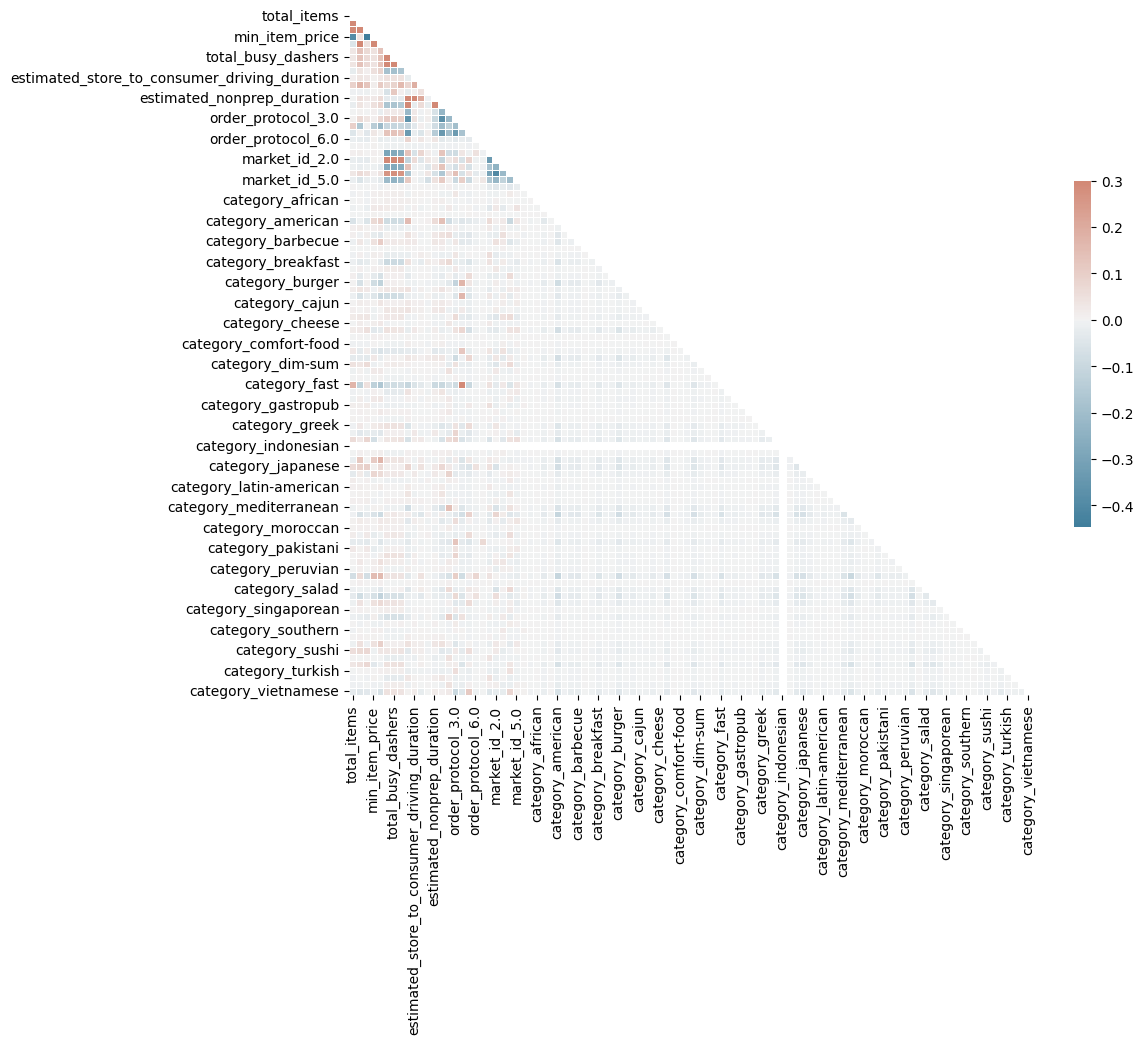

In [35]:
#Setting up the matplotlib figure
f,ax = plt.subplots(figsize=(11,9))

#Generating a custom diverging colormap 
cmap = sns.diverging_palette(230,20,as_cmap=True)

#Drawing the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.3,center=0,
            square=True,linewidths=.5,cbar_kws={"shrink": .5})

In [36]:
#There's no correlation for 'category_indonesian', therefore we will drop this as it doesnt produce any impact
df2["category_indonesian"].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

In [37]:
def get_redundant_pairs(df): 
    '''Obtain the diagornal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns 
    for i in range(0,df.shape[1]):
        for j in range(0,i+1):
            pairs_to_drop.add((cols[i],cols[j]))
    return pairs_to_drop

In [38]:
def get_top_abs_correlation(df, n=5):
    au_corr = df.corr().abs().unstack() 
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [39]:
print("Top Absolute Correlation")
print(get_top_abs_correlation(df2,20))

Top Absolute Correlation


total_onshift_dashers                         total_busy_dashers            0.941741
                                              total_outstanding_orders      0.934639
total_busy_dashers                            total_outstanding_orders      0.931295
estimated_store_to_consumer_driving_duration  estimated_nonprep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0            0.897645
total_items                                   num_distinct_items            0.758146
subtotal                                      num_distinct_items            0.682890
total_items                                   subtotal                      0.557175
min_item_price                                max_item_price                0.541241
subtotal                                      max_item_price                0.507947
order_protocol_4.0                            category_fast                 0.489946
num_distinct_items                            min_item_price     

In [40]:
df2.shape 

(177070, 100)

In [41]:
#generating new df2 based on the correlation , the only change is on pd.concat where previously we concatenated "market_id_dummies"
df2 = df.drop(columns=["created_at","market_id","store_id","store_primary_category","actual_delivery_time",
                       "nan_free_store_primary_category","order_protocol"])

df2 = pd.concat([df2,order_protocol_dummies,store_primary_category_dummies],axis=1)  

#dropping these columns since they are highly correlated 
#reason  : we can see that total_onshift_dashers, total_busy_dashers, total_outstanding_orders  correlated to each other , so we decided to only keep total_outstanding_orders , this will remove redundancy 
#reason  : removing category_indonesian since there's no correlation at all in the heatmap 
#reason  : we can see that estimated_nonprep_duration and estimated_store_to_consumer_driving_duration are highly correlated to each other , since estimated_nonprep_duration is something we created , we decided to remove it 
df2 = df2.drop(columns=["total_onshift_dashers","total_busy_dashers","category_indonesian","estimated_nonprep_duration"])

df2 = df2.astype("float32") 
df2.replace([np.inf,-np.inf], np.nan, inplace=True) 
df2.dropna(inplace=True)  

df2.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
df2.shape #removed 10 columns

(177070, 90)

In [43]:
#calculating the new correlation based on amended dataframe
print("Top Absolute Correlations")
print(get_top_abs_correlation(df2,20)) 

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

In [44]:
df2 = df.drop(columns=["created_at","market_id","store_id","store_primary_category","actual_delivery_time",
                       "nan_free_store_primary_category","order_protocol"])

#since order_protocol_dummies are not correlated , we are not concatenating  
df2 = pd.concat([df2,store_primary_category_dummies],axis=1)

df2 = df2.drop(columns=["total_onshift_dashers","total_busy_dashers",
                        "category_indonesian","estimated_nonprep_duration"])

#aligning the dtype over the dataset 
df2 = df2.astype("float32") 
df2.replace([np.inf,-np.inf], np.nan, inplace=True) 
df2.dropna(inplace=True)  

df2.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
df2.shape #removed another 7 columns

(177070, 83)

In [45]:
print("Top Absolute Correlations")
print(get_top_abs_correlation(df2,20)) 

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_delivery_duration          0.188418
subtotal                                      actual_delivery_duration          0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.17

In [46]:
#Since there's still high correlations, we're will be using feature engineering
#Feature engineering : It is a technique that create new variables to simplify the model and increase its accuracy by using the new variables as predictors 

#Note that in the above part , subtotal,total_items,num_distinct_items have high correlation
#We combine them to form a new feature 
df2["percent_distinct_item_of_total"] = df2["num_distinct_items"] / df["total_items"]
df2["avg_price_per_item"] = df2["subtotal"] / df["total_items"]

In [47]:
print("Top Absolute Correlations")
print(get_top_abs_correlation(df2,20)) 

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.31

In [48]:
#Now we have max_item_price and min_item_price showing high correlation, so we're doing feature engineering again
df2["price_range_of_items"] = df2["max_item_price"]-df2["min_item_price"] 

#Dropping highly correlated features again to remove redundancy 
df2.drop(columns=["max_item_price","min_item_price","num_distinct_items","subtotal"],inplace=True)

In [49]:
print("Top Absolute Correlations")
print(get_top_abs_correlation(df2,20))  

#Now we can see that the max correlation is 0.44 , so we dont have to remove anyhing 

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_delivery_duration          0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_delivery_duration          0.15

### 3. Multicollinearity and Feature Selection 

Multicollinearity is a statistical phenomenon in regression analysis where two or more independent variables in a model are highly correlated. In other words, it occurs when there is a strong linear relationship between two or more predictor variables.


In [50]:
#We will use VIF (variance inflation factor) to quantify the severity of multicollinearity (we remove feature with VIF score over 20)

'''
#Manual way of calculating the VIF 

import statsmodels.api as sm 
def compute_vif1(features_names,features_data): 
    vif_data = pd.DataFrame(features_data,columns=features_names) 
    
    for i in range(0,len(features_names)):
        y = vif_data.loc[:, vif_data.columns == features_names[i]]
        x = vif_data.loc[:, vif_data.columns != features_names[i]]

        model = sm.OLS(y,x)
        results = model.fit()
        rsq = results.rsquared
        vif = round(1/(1-rsq),2)

        print("R squared of {} column is {} keeping all other columns as features".format(features_names[i],round(rsq,2)))
        print("VIF of {} column is {} \n".format(features_names[i],vif)) 

feature_data = df2.drop(columns=["actual_delivery_duration"])
features = df2.drop(columns=["actual_delivery_duration"]).columns.to_list()   
vif_data = compute_vif1(features,feature_data)   
vif_data 
'''

#Using the function 'variance_inflation_factor'
from statsmodels.stats.outliers_influence import variance_inflation_factor   

def compute_vif(features): 
    vif_data = pd.DataFrame() 
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df2[features].values,i) for i in range(len(features))]
    return vif_data.sort_values(by=["VIF"]).reset_index(drop=True)   

In [51]:
#Computing the VIF 
features = df2.drop(columns=["actual_delivery_duration"]).columns.to_list()   
vif_data = compute_vif(features) 
vif_data   

,feature,VIF
0,category_alcohol-plus-food,1.000369
1,category_chocolate,1.000488
2,category_belgian,1.000749
3,category_russian,1.003225
4,category_african,1.003820
...,...,...
76,busy_dashers_ratio,6.369592
77,category_american,7.033601
78,estimated_store_to_consumer_driving_duration,7.210812
79,estimated_order_place_duration,13.472106


In [52]:
# removing features with VIF more than or equal to 20 
multicol_free_features = vif_data[vif_data["VIF"] < 20]
selected_features = multicol_free_features["feature"].tolist()
selected_features 

['category_alcohol-plus-food',
 'category_chocolate',
 'category_belgian',
 'category_russian',
 'category_african',
 'category_gluten-free',
 'category_european',
 'category_spanish',
 'category_comfort-food',
 'category_cheese',
 'category_moroccan',
 'category_singaporean',
 'category_southern',
 'category_kosher',
 'category_irish',
 'category_soup',
 'category_argentine',
 'category_german',
 'category_afghan',
 'category_malaysian',
 'category_tapas',
 'category_ethiopian',
 'category_pakistani',
 'category_british',
 'category_lebanese',
 'category_gastropub',
 'category_turkish',
 'category_convenience-store',
 'category_peruvian',
 'category_vegan',
 'category_caribbean',
 'category_brazilian',
 'category_filipino',
 'category_nepalese',
 'category_bubble-tea',
 'category_cajun',
 'category_latin-american',
 'category_french',
 'category_persian',
 'category_pasta',
 'category_burmese',
 'category_vegetarian',
 'category_dim-sum',
 'category_steak',
 'category_smoothie',
 'cat

Feature selection is being carried out to reduce the dimension of data set by removing features that doesnt bring significant effect to the model. It also helps the algorithm to run faster. 

2 ways : PCA and Random forest regressor

In [53]:
#1) Random Forest with gini importance to measure the importance of each feature 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

X = df2[selected_features]
y = df2["actual_delivery_duration"]
 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42) 


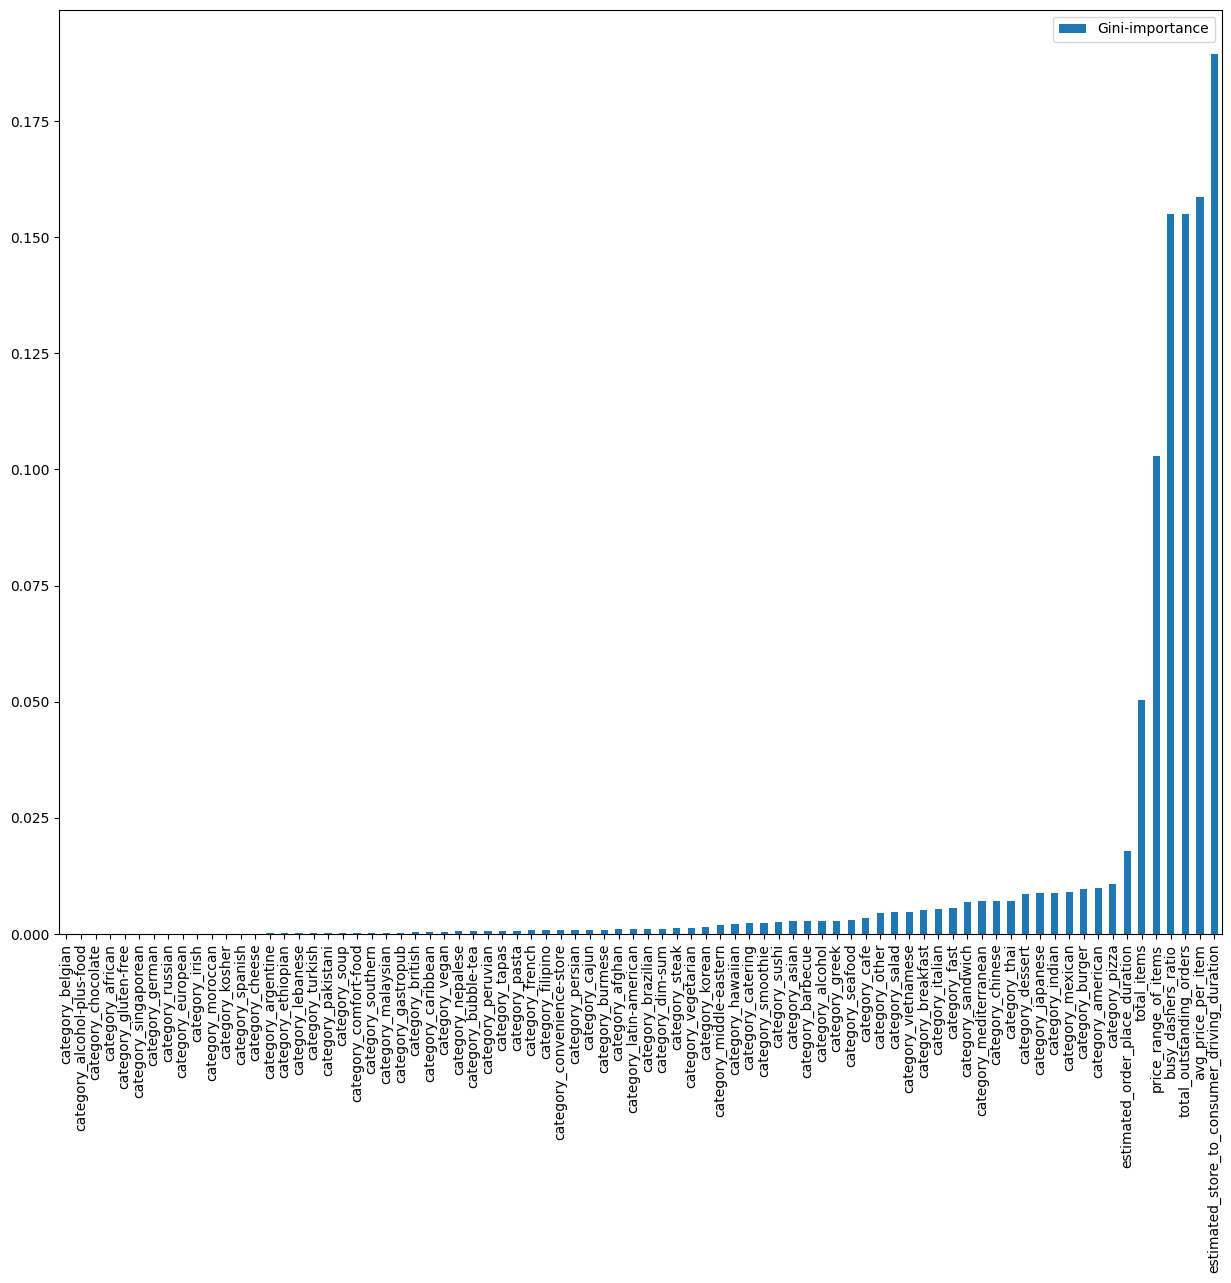

In [54]:
feature_names = [f"feature{i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42) 
forest.fit(X_train,y_train)
feats = {} # a dict to hold feature name(key) : feature_importance(value)

for feature,importance in zip(X.columns,forest.feature_importances_):
    feats[feature] = importance 

importances = pd.DataFrame.from_dict(feats,orient='index').rename(columns={0:'Gini-importance'})
importances.sort_values(by="Gini-importance").plot(kind='bar',rot=90,figsize=(15,12)) 
plt.show()  

In [55]:
#Getting the 35 most important features 
importances.sort_values(by="Gini-importance")[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_mediterranean',
 'category_chinese',
 'category_thai',
 'category_dessert',
 'category_japanese',
 'category_indian',
 'category_mexican',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

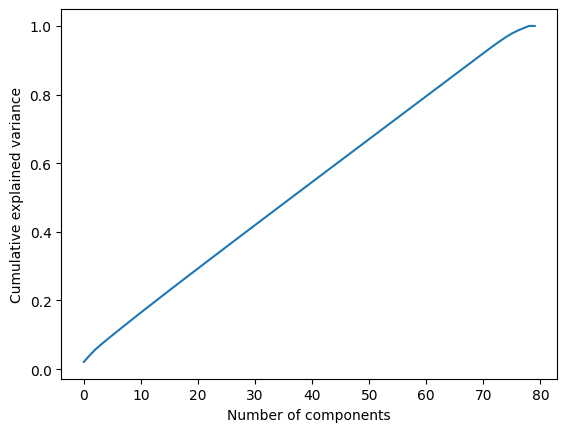

In [56]:
# 2) PCA - analyse how many features required to explain any percentage of our data , shows optimum number of features to explain our dataset 

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 

X_Train = X_train.values 
X_Train = np.asarray(X_Train)

#Finding normalised array of X_train
X_std = StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlim(0,81,1)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()


In [57]:
#Scaling the features  
from sklearn.preprocessing import MinMaxScaler, StandardScaler 

In [58]:
def scale(scaler,X,y): 
    X_scaler = scaler  
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1,1))
    y_scaled = y_scaler.transform(y.values.reshape(-1,1))

    return X_scaled, y_scaled, X_scaler, y_scaler  

In [60]:
#example usage 
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42 
)

In [92]:
from sklearn.metrics import mean_squared_error 

#rmse shows the difference between the prediction and real value 
def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    '''Convert the scaled error to actual error'''
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    #return RMSE with squared False
    rmse_error = mean_squared_error(y_test,y_predict[:,0],squared=False)
    print("Error = "'{}'.format(rmse_error)+" in "+model_name) 

    return rmse_error,y_predict


### 4. Model Training

In [67]:
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree  
from sklearn import svm 
from sklearn import neighbors 
from sklearn import linear_model  

In [94]:
#create a generic function which can work with multiple machine learning models 
def make_regression(X_train,y_train,X_test,y_test,model,model_name, verbose=True):
    '''Apply selected regression model to data and measure error'''
    model.fit(X_train,y_train) 
    y_predict = model.predict(X_train)
    train_error = mean_squared_error(y_train,y_predict,squared=False)  
    y_predict = model.predict(X_test) 
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("\nTrain error = "'{}'.format(train_error)+" in "+model_name) 
        print("Test error = "'{}'.format(test_error)+" in "+model_name)
    trained_model = model 
 
    return trained_model , y_predict , train_error , test_error  

In [72]:
#Generating four different dictionaries to store predictions, prediction models, feature sets, and scalers 
#We will get a set of 72 results (6 algorithms , 4 different sets , 3 different scalers  6x4x3=72)

pred_dict = {
    "regression_model" : [],
    "feature_set" : [],
    "scaler_name" : [],
    "RMSE" : [],
}

regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost" : XGBRegressor(),
    "LGBM" : LGBMRegressor(),
    "MLP" : MLPRegressor()  
}

feature_sets = { 
    "full dataset" : X.columns.to_list(),
    "selected_feature_40" : importances.sort_values(by="Gini-importance")[-40:].index.tolist(),
    "selected_feature_20" : importances.sort_values(by="Gini-importance")[-20:].index.tolist(),
    "selected_feature_10" : importances.sort_values(by="Gini-importance")[-10:].index.tolist()
}

scalers = { 
    "StandardScaler" : StandardScaler(), 
    "MinimaxScaler" : MinMaxScaler(),
    "NotScaled" : None
}


In [98]:
for feature_set_name in feature_sets.keys(): 
    feature_set = feature_sets[feature_set_name] 
    for scaler_name in scalers.keys():
        print(f"----scaled with {scaler_name}----included columns {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            if scaler_name == "NotScaled":
                X = df2[feature_set]
                y = df2["actual_delivery_duration"]
                X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
                make_regression(X_train,X_test, y_train, y_test, regression_models[model_name],model_name,verbose=True)

            else:
                X_scaled,y_scaled,X_scaler,y_scaler = scale(scalers[scaler_name], X[feature_set],y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2,random_state=42
                )

                # print(X_train_scaled.shape, y_train_scaled.shape, X_test_scaled.shape, y_test_scaled.shape)

                _, y_predict_scaled ,_,_ = make_regression(X_train_scaled, y_train_scaled[:,0],X_test_scaled,y_test_scaled, regression_models[model_name],model_name,verbose=True)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler,y_test,y_predict_scaled,model_name)

                #appending the values into the dictionary for every calculation
                pred_dict["regression_model"].append(model_name) 
                pred_dict["feature_set"].append(feature_set_name)
                pred_dict["scaler_name"].append(scaler_name) 
                pred_dict["RMSE"].append(rmse_error) 

# This block takes a long time to compute especially for RandomForest  

In [103]:
#This will convert the dictionary into dataframe  
pred_df = pd.DataFrame(pred_dict)
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,fullDataset,StandardScaler,2053.698550
1,DecisionTree,fullDataset,StandardScaler,2057.247669
2,Ridge,fullDataset,StandardScaler,2053.698550
3,DecisionTree,fullDataset,StandardScaler,2057.247669
4,RandomForest,fullDataset,StandardScaler,2048.557688
5,XGBoost,fullDataset,StandardScaler,2035.815430
6,LGBM,fullDataset,StandardScaler,2033.435581
7,MLP,fullDataset,StandardScaler,2037.672370
8,Ridge,fullDataset,MinimaxScaler,2053.964732
9,DecisionTree,fullDataset,MinimaxScaler,2057.247669


In [105]:
#Create a bar plot of RMSE against the each row to check which one produces the least RMSE 
pred_df.plot(kind="bar",figsize=(12,8))

In [106]:
#Changing the approach for the problem slightly where we predict the prep_time first , then we predict the actual_delivery_duration
#This to try if this way we can reduce the MSE
df2['prep_time'] = df2["actual_delivery_duration"] - df2["estimated_store_to_consumer_driving_duration"] - df2["estimated_order_place_duration"]

In [ ]:
feature_sets = { 
    "selected_feature_40" : importances.sort_values(by="Gini-importance")[-40:].index.tolist(),
}

scalers = { 
    "StandardScaler" : StandardScaler(), 
}

In [109]:
#We are trying to predict the preparation time ("prep_time") 
for feature_set_name in feature_sets.keys(): 
    feature_set = feature_sets[feature_set_name] 
    for scaler_name in scalers.keys():
        print(f"----scaled with {scaler_name}----included columns {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            
            #we're dropping these two features because we've calculated prep_time using the below two columns, to
            #avoid collinearity, we can remove them 
            X = df2[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration",
                                                "estimated_order_place_duration"])
            y = df2["prep_time"] 
            X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
            
            #obtaining the indices 
            train_indices = X_train.index
            test_indices = X_test.index

            #scale        
            X_scaled,y_scaled,X_scaler,y_scaler = scale(scalers[scaler_name], X,y)
            
            #applying index 
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                X_scaled, y_scaled, test_size=0.2,random_state=42
            )
            _, y_predict_scaled ,_,_ = make_regression(X_train_scaled, y_train_scaled[:,0],X_test_scaled,y_test_scaled[:,0], regression_models[model_name],model_name,verbose=True)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler,y_test,y_predict_scaled,model_name)

            #appending the values into the dictionary for every calculation
            pred_dict["regression_model"].append(model_name) 
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name) 
            pred_dict["RMSE"].append(rmse_error) 

# The computation for this block also takes long time (analysation shows that LGBM scores the best).  

In [111]:
regression_models = {
    "LGBM" : LGBMRegressor()
}

feature_sets = { 
    "selected_feature_40" : importances.sort_values(by="Gini-importance")[-40:].index.tolist(),
}

scalers = { 
    "StandardScaler" : StandardScaler(),  
}

In [112]:
#Running this to recheck specifically for LGBM
for feature_set_name in feature_sets.keys():  
    feature_set = feature_sets[feature_set_name] 
    for scaler_name in scalers.keys():
        print(f"----scaled with {scaler_name}----included columns {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            
            #we're dropping these two features because we've calculated prep_time using the below two columns, (due to collinearity issues, we're removing them) 
            X = df2[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration",
                                                "estimated_order_place_duration"])
            y = df2["prep_time"] 
            X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
            
            #obtaining the indices
            train_indices = X_train.index
            test_indices = X_test.index

            #scale        
            X_scaled,y_scaled,X_scaler,y_scaler = scale(scalers[scaler_name], X,y)
            
            #applying index 
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                X_scaled, y_scaled, test_size=0.2,random_state=42
            )
            _, y_predict_scaled ,_,_ = make_regression(X_train_scaled, y_train_scaled[:,0],X_test_scaled,y_test_scaled[:,0], regression_models[model_name],model_name,verbose=True)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler,y_test,y_predict_scaled,model_name) 

            #appending the values into the dictionary for every calculation
            pred_dict["regression_model"].append(model_name) 
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name) 
            pred_dict["RMSE"].append(rmse_error)

----scaled with StandardScaler----included columns selected_feature_40

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 38
[LightGBM] [Info] Start training from score -0.002301

Train error = 0.7484992880216514 in LGBM
Test error = 1.490142572482501 in LGBM
Error = 2035.7236370573405 in LGBM


In [114]:
#To choose best performing model and extract the predictions for preparation duration 
pred_values_dict = {
    "actual_delivery_duration" : df2["actual_delivery_duration"][test_indices].values.tolist(),
    "prep_duration_prediction" : y_predict[:,0].tolist(), #prediction for prep_time which was predicted using LGBM
    "estimated_store_to_consumer_driving_duration" : df2["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration" : df2["estimated_order_place_duration"][test_indices].values.tolist()
} 

In [117]:
values_df = pd.DataFrame.from_dict(pred_values_dict) 
values_df 

,actual_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1734.115287,380.0,251.0
1,1839.0,1508.588146,747.0,446.0
2,1927.0,2141.085685,543.0,251.0
3,2657.0,1312.559865,445.0,251.0
4,3596.0,1945.871826,691.0,446.0
...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0
35410,1864.0,2148.159250,324.0,446.0
35411,2674.0,1939.286320,791.0,251.0
35412,2234.0,1930.656157,687.0,251.0


In [118]:
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"]+values_df["estimated_order_place_duration"]+values_df["estimated_store_to_consumer_driving_duration"]
values_df

,actual_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1734.115287,380.0,251.0,2365.115287
1,1839.0,1508.588146,747.0,446.0,2701.588146
2,1927.0,2141.085685,543.0,251.0,2935.085685
3,2657.0,1312.559865,445.0,251.0,2008.559865
4,3596.0,1945.871826,691.0,446.0,3082.871826
...,...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0,3837.132706
35410,1864.0,2148.159250,324.0,446.0,2918.159250
35411,2674.0,1939.286320,791.0,251.0,2981.286320
35412,2234.0,1930.656157,687.0,251.0,2868.656157


In [120]:
#Checking the new method can reduce the MSE but unfortunately the MSE is still high.  
mean_squared_error(values_df["actual_delivery_duration"],values_df["sum_total_delivery_duration"],squared=False)

2035.7236370573405

In [122]:
#We're trying to use another regression to find the actual_delivery_duration (which is our main target variable) by using features as shown in X  
X = values_df[["prep_duration_prediction","estimated_store_to_consumer_driving_duration","estimated_order_place_duration"]]
y = values_df["actual_delivery_duration"]
X_train, X_test, y_train, y_test= train_test_split(
                X, y, test_size=0.2,random_state=42
            )    


In [124]:
regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost" : XGBRegressor(),
    "LGBM" : LGBMRegressor(),
    "MLP" : MLPRegressor()  
}

#Since this approach reduce the RMSE nearly half , we can choose this approach as the solution (In this case , Linear regression performs the best with the RMSE of 986.69)  
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(
        X_train, y_train,X_test,y_test, regression_models[model_name],model_name,verbose=True)
    print("RMSE of : ",model_name,mean_squared_error(y_test,y_predict,squared=False)) 


Train error = 2220.715219329592 in Ridge
Test error = 986.6912510344928 in Ridge
RMSE of :  Ridge 986.6912510344928

Train error = 1017.2210842056404 in DecisionTree
Test error = 1235.578088153976 in DecisionTree
RMSE of :  DecisionTree 1235.578088153976

Train error = 988.11213462828 in RandomForest
Test error = 1271.057327439655 in RandomForest
RMSE of :  RandomForest 1271.057327439655

Train error = 902.2952285684272 in XGBoost
Test error = 1034.7085905354322 in XGBoost
RMSE of :  XGBoost 1034.7085905354322
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 28331, number of used features: 3
[LightGBM] [Info] Start training from score 2869.174261

Train error = 1871.969930115998 in LGBM
Test error = 1079.2949179771774 in LGBM
RMSE of :  LGBM 1079.2949179771774

Train error = 2221.5608

Official solution is LGBM and Linear Regression on top. 

- Intially we predict prep_time using LGBM 
- Then we use prep_time and few other features to predict actual_duration using Linear Regression 

### Deep Learning approach

In [126]:
#Now we're trying to compare the performance with the help of deep learning methods  
import keras 
from keras.models import Sequential 
from keras.layers import Dense 
import tensorflow as tf 
tf.random.set_seed(42)

In [127]:
def create_model(feature_set_size):
    #defining a model
    model = Sequential()
    model.add(Dense(16,input_dim=feature_set_size,activation='relu'))
    model.add(Dense(1,activation='linear'))

    #compiling the model (stochastic gradient descent as optimizer, mse as loss function) 
    model.compile(optimizer="sgd",loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model 

In [130]:
print("f--------------scaled with {scaler_name}------------included columns are {feature_set_name}")
print("")

model_name = "ANN"
scaler_name = "StandardScaler"
X = values_df[["prep_duration_prediction","estimated_store_to_consumer_driving_duration","estimated_order_place_duration"]]
y = values_df["actual_delivery_duration"]
X_train, X_test, y_train, y_test= train_test_split(
                X, y, test_size=0.2,random_state=42
            )

#scale        
X_scaled,y_scaled,X_scaler,y_scaler = scale(scalers[scaler_name], X,y)

#applying index 
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2,random_state=42
)

print("feature_set_size : ",X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler,y_test,y_pred,model_name)

pred_dict["regression_model"].append(model_name) 
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name) 
pred_dict["RMSE"].append(rmse_error)  


f--------------scaled with {scaler_name}------------included columns are {feature_set_name}

feature_set_size :  3


Epoch 1/100

443/443 [==============================] - 2s 3ms/step - loss: 1.1260 - root_mean_squared_error: 1.0611
Epoch 2/100
443/443 [==============================] - 2s 3ms/step - loss: 1.1190 - root_mean_squared_error: 1.0578
Epoch 3/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1182 - root_mean_squared_error: 1.0575
Epoch 4/100
443/443 [==============================] - 2s 4ms/step - loss: 1.1181 - root_mean_squared_error: 1.0574
Epoch 5/100
443/443 [==============================] - 2s 4ms/step - loss: 1.1177 - root_mean_squared_error: 1.0572
Epoch 6/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1177 - root_mean_squared_error: 1.0572
Epoch 7/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1176 - root_mean_squared_error: 1.0572
Epoch 8/100
443/443 [==============================] - 1s 3ms/step - l

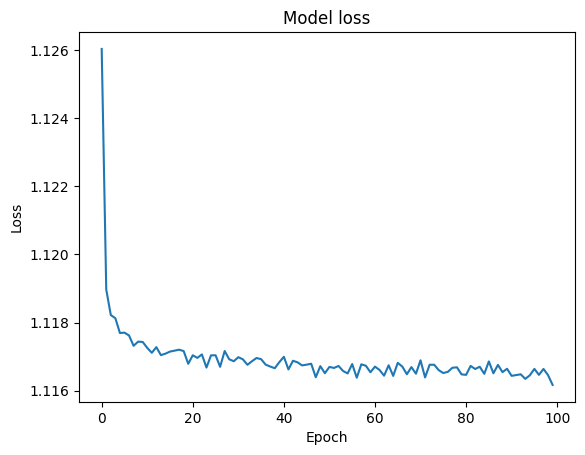

In [132]:
plt.plot(history.history['loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show() 